In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm
from scipy.signal import stft
from scipy.stats import kurtosis
from torchsummary import summary
from tabulate import tabulate

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [13]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [3]:
datasets.Dataset('PRONOSTIA').describe()

PRONOSTIA

Description
The IEEE PHM data challenge in 2012 utilized a renowned dataset provided by the FEMTO-ST Institute. The dataset originated from experiments conducted on a laboratory experimental platform known as PRONOSTIA, designed for accelerated degradation testing of bearings under various operating conditions. During these experiments, online health monitoring data including rotating speed, load force, temperature, and vibration were collected.

The dataset considered data from three different loads, encompassing rotating speed and load force variations. A total of 6 run-to-failure bearings were designated for building prognostic models, while an additional 11 bearings were allocated for testing purposes.

One notable characteristic of the challenge datasets was the relatively small amount of training data available, coupled with a high variability in experiment durations ranging from 1 to 7 hours. This variability posed a significant challenge in accurately estimating prog

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:36<00:00, 383.73it/s]
INFO:root:Read in 61.945133447647095 seconds


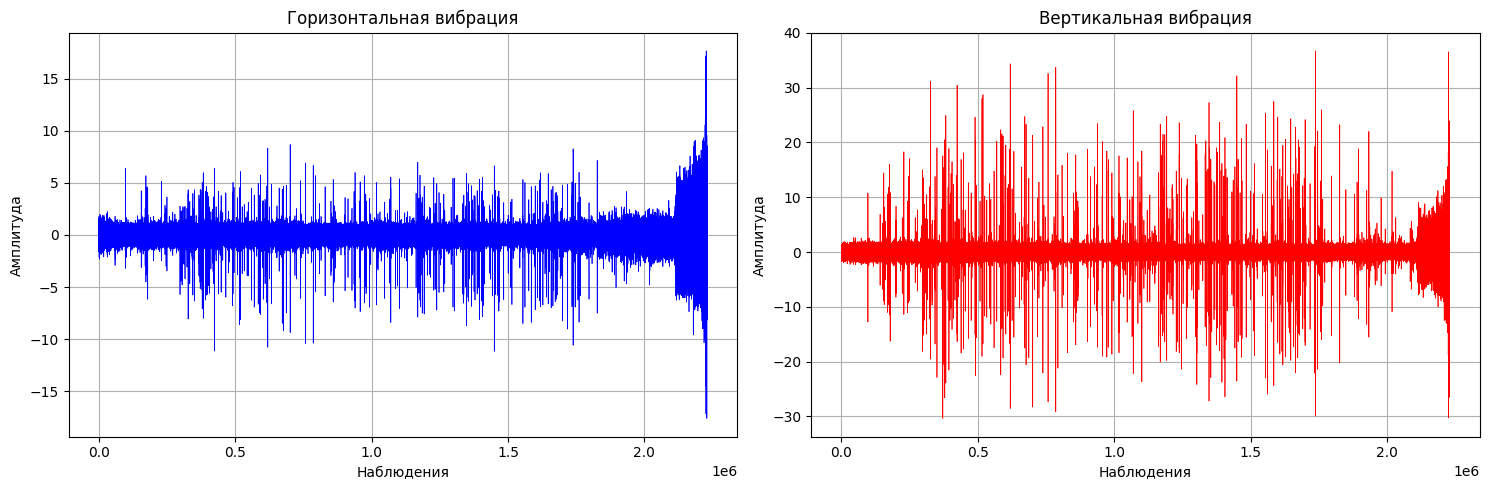

In [9]:
d_1_1 = df[0][df[0]['unit'] == '1_1']
d_1_2 = df[0][df[0]['unit'] == '1_2']
d_2_1 = df[0][df[0]['unit'] == '2_1']
d_2_2 = df[0][df[0]['unit'] == '2_2']
d_3_1 = df[0][df[0]['unit'] == '3_1']
d_3_2 = df[0][df[0]['unit'] == '3_2']

# Create a figure with 1 row and 2 columns (side-by-side plots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot H_acc (horizontal vibration) on the left
ax1.plot(d_1_2['H_acc'], color='blue', linewidth=0.5)
ax1.set_title('Горизонтальная вибрация')
ax1.set_xlabel('Наблюдения')
ax1.set_ylabel('Амплитуда')
ax1.grid(True)

# Plot V_acc (vertical vibration) on the right
ax2.plot(d_1_2['V_acc'], color='red', linewidth=0.5)
ax2.set_title('Вертикальная вибрация')
ax2.set_xlabel('Наблюдения')
ax2.set_ylabel('Амплитуда')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

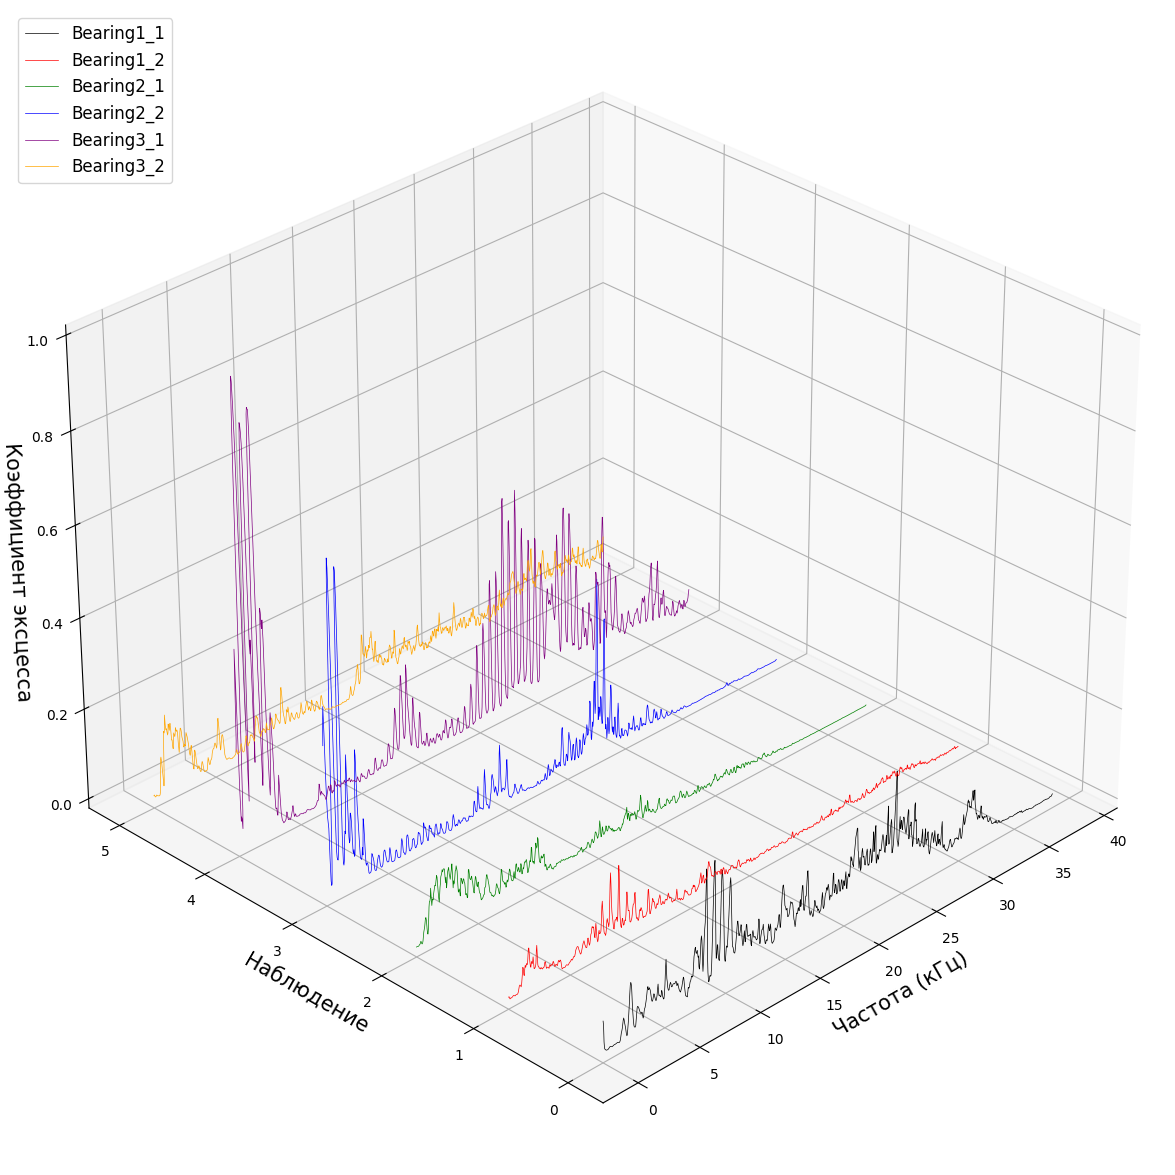

In [45]:
f = []
ffts = []

nperseg = 1024
TRAIN_BEARINGS_LIST = [bearing for bearings_list in TRAIN_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
}

for bearing in TRAIN_BEARINGS_LIST:
    data = df[0][df[0]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)


def plot_3d_bearing_kurtosis(f, bearings_list, label_colors):
    n = np.ones_like(f[0])

    fig = plt.figure(figsize = (15.0, 15.0))
    ax = plt.axes(projection = '3d')
    ax.view_init(30,225)
    for i in range(f.shape[0]):
        ax.plot(
            (f[i] * 3) / 1.0e3,
            i * n,
            fftn[i],
            color=label_colors[i],
            linewidth = 0.50,
            label='Bearing' + bearings_list[i],
        )

    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Частота (кГц)', fontsize=15)
    ax.set_ylabel('Наблюдение', fontsize=15)
    ax.set_zlabel('Коэффициент эксцесса', fontsize=15)
    plt.show()

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TRAIN_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

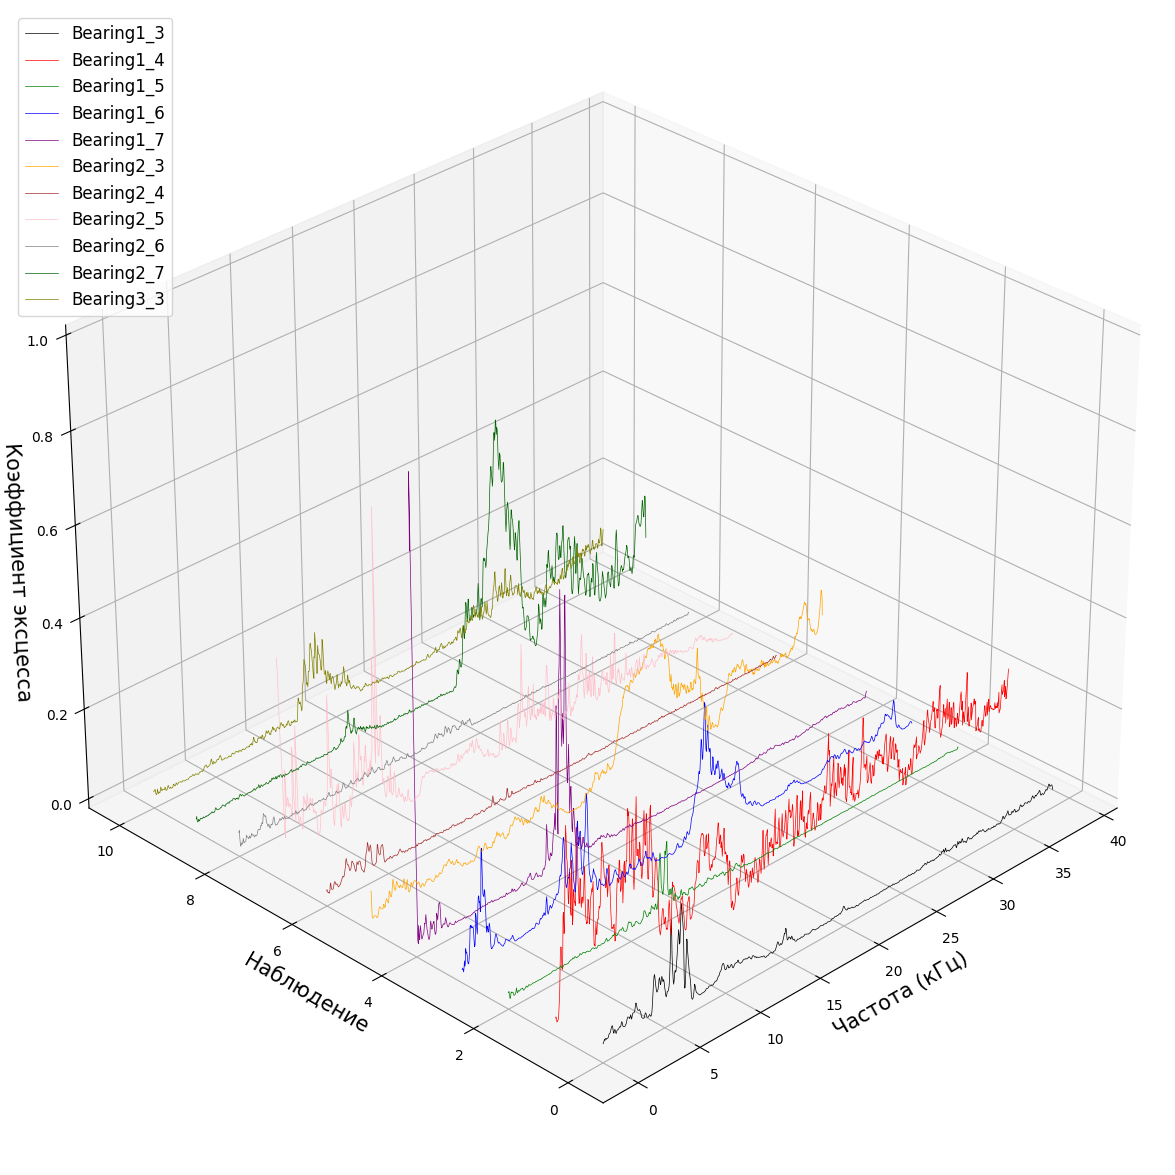

In [47]:
f = []
ffts = []

nperseg = 1024
TEST_BEARINGS_LIST = [bearing for bearings_list in TEST_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'darkgreen',
    10: 'olive',
}

for bearing in TEST_BEARINGS_LIST:
    data = df[1][df[1]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TEST_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


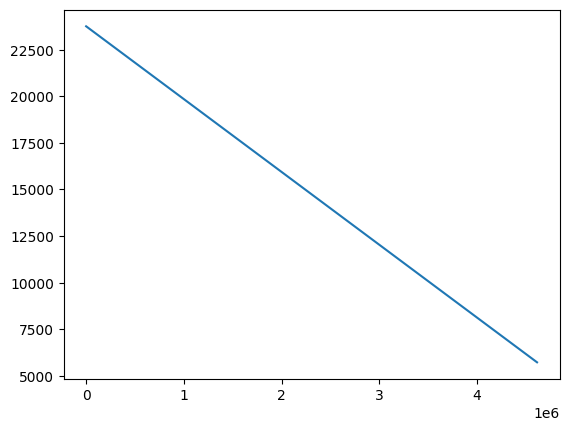

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [106]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for _, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_7'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [248]:
len(train_dataset)

1820

In [133]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super(BearingCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=1, padding=2),  # [32, 16, 2560]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 16, 1280]
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # [32, 32, 1280]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 32, 640]
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # [32, 64, 640]
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)                                 # [32, 64, 1]
        )
        
        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)       # [32, 64, 1]
        x = x.squeeze(-1)          # [32, 64]
        x = self.regressor(x)      # [32, 1]
        return x

model = BearingCNN()
# model.load_state_dict(torch.load('last_r2_model.pth', weights_only=True))

In [134]:
# def model_summary_table(model, input_shape):
#     # Get summary as a string
#     summary_str = []
#     def hook(module, input, output):
#         summary_str.append([
#             module.__class__.__name__,
#             list(input[0].shape) if isinstance(input, tuple) else input.shape,
#             list(output.shape),
#             sum(p.numel() for p in module.parameters())
#         ])
    
#     # Register hooks
#     hooks = []
#     for layer in model.children():
#         hooks.append(layer.register_forward_hook(hook))
    
#     # Dummy forward pass
#     dummy_input = torch.randn(input_shape)
#     model(dummy_input)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     # Print table
#     headers = ["Layer (type)", "Input Shape", "Output Shape", "Param #"]
#     print(tabulate(summary_str, headers=headers, tablefmt="grid"))

# summary(model, input_size=(2560, 2), batch_size=32, device='cpu')

In [135]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.5
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val)

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    torch.save(model.state_dict(), 'last_r2_model.pth')

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [136]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 176/176 [00:00<00:00, 250.95it/s]


Epoch 1: Train Loss 15553.3152, Train R2 = 0.022, Train RMSE = 0.285, Train MSE = 0.081, Train MAE = 0.153


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 609.80it/s]


Epoch 1: Val Loss 4274.7507, Val R2 = -1.917, Val RMSE = 0.493, Val MSE = 0.243, Val MAE = 0.407


100%|██████████| 176/176 [00:00<00:00, 266.44it/s]


Epoch 2: Train Loss 12597.6318, Train R2 = 0.183, Train RMSE = 0.261, Train MSE = 0.068, Train MAE = 0.176


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 593.58it/s]


Epoch 2: Val Loss 4511.6929, Val R2 = -2.079, Val RMSE = 0.506, Val MSE = 0.256, Val MAE = 0.422


100%|██████████| 176/176 [00:00<00:00, 262.08it/s]


Epoch 3: Train Loss 17547.0471, Train R2 = 0.036, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.195


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 563.31it/s]


Epoch 3: Val Loss 4220.4946, Val R2 = -1.885, Val RMSE = 0.490, Val MSE = 0.240, Val MAE = 0.403


100%|██████████| 176/176 [00:00<00:00, 269.59it/s]


Epoch 4: Train Loss 22768.4495, Train R2 = 0.040, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.214


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 551.90it/s]


Epoch 4: Val Loss 3689.4674, Val R2 = -1.484, Val RMSE = 0.455, Val MSE = 0.207, Val MAE = 0.374


100%|██████████| 176/176 [00:00<00:00, 272.87it/s]


Epoch 5: Train Loss 39214.5757, Train R2 = -1.562, Train RMSE = 0.462, Train MSE = 0.213, Train MAE = 0.360


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 588.16it/s]


Epoch 5: Val Loss 2549.1589, Val R2 = -0.732, Val RMSE = 0.380, Val MSE = 0.144, Val MAE = 0.307


100%|██████████| 176/176 [00:00<00:00, 270.71it/s]


Epoch 6: Train Loss 64946.6940, Train R2 = -0.205, Train RMSE = 0.317, Train MSE = 0.100, Train MAE = 0.218


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 568.97it/s]


Epoch 6: Val Loss 3432.0022, Val R2 = -1.176, Val RMSE = 0.425, Val MSE = 0.181, Val MAE = 0.344


100%|██████████| 176/176 [00:00<00:00, 271.95it/s]


Epoch 7: Train Loss 28818.9013, Train R2 = -0.175, Train RMSE = 0.313, Train MSE = 0.098, Train MAE = 0.264


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 574.53it/s]


Epoch 7: Val Loss 1920.5869, Val R2 = -0.115, Val RMSE = 0.304, Val MSE = 0.093, Val MAE = 0.259


100%|██████████| 176/176 [00:00<00:00, 283.66it/s]


Epoch 8: Train Loss 18556.4647, Train R2 = -0.195, Train RMSE = 0.315, Train MSE = 0.100, Train MAE = 0.262


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 505.50it/s]


Epoch 8: Val Loss 1932.1834, Val R2 = -0.288, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.271


100%|██████████| 176/176 [00:00<00:00, 261.44it/s]


Epoch 9: Train Loss 16559.3779, Train R2 = -0.079, Train RMSE = 0.300, Train MSE = 0.090, Train MAE = 0.246


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 483.67it/s]


Epoch 9: Val Loss 1750.9721, Val R2 = -0.169, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.261


100%|██████████| 176/176 [00:00<00:00, 242.62it/s]


Epoch 10: Train Loss 14082.7395, Train R2 = 0.134, Train RMSE = 0.269, Train MSE = 0.072, Train MAE = 0.214


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 602.22it/s]


Epoch 10: Val Loss 1937.0513, Val R2 = -0.320, Val RMSE = 0.331, Val MSE = 0.110, Val MAE = 0.271


100%|██████████| 176/176 [00:00<00:00, 274.91it/s]


Epoch 11: Train Loss 13845.9274, Train R2 = 0.097, Train RMSE = 0.274, Train MSE = 0.075, Train MAE = 0.221


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 572.64it/s]


Epoch 11: Val Loss 1756.2116, Val R2 = -0.172, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.261


100%|██████████| 176/176 [00:00<00:00, 272.49it/s]


Epoch 12: Train Loss 13066.9636, Train R2 = 0.152, Train RMSE = 0.266, Train MSE = 0.071, Train MAE = 0.216


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 600.84it/s]


Epoch 12: Val Loss 1724.0193, Val R2 = -0.161, Val RMSE = 0.311, Val MSE = 0.097, Val MAE = 0.259


100%|██████████| 176/176 [00:00<00:00, 283.33it/s]


Epoch 13: Train Loss 11547.6318, Train R2 = 0.255, Train RMSE = 0.249, Train MSE = 0.062, Train MAE = 0.200


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 610.14it/s]


Epoch 13: Val Loss 1779.7821, Val R2 = -0.200, Val RMSE = 0.316, Val MSE = 0.100, Val MAE = 0.262


100%|██████████| 176/176 [00:00<00:00, 283.60it/s]


Epoch 14: Train Loss 10747.4055, Train R2 = 0.299, Train RMSE = 0.242, Train MSE = 0.058, Train MAE = 0.194


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 632.31it/s]


Epoch 14: Val Loss 1711.8058, Val R2 = -0.145, Val RMSE = 0.309, Val MSE = 0.095, Val MAE = 0.257


100%|██████████| 176/176 [00:00<00:00, 279.45it/s]


Epoch 15: Train Loss 9791.9770, Train R2 = 0.377, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.178


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 585.38it/s]


Epoch 15: Val Loss 1675.7053, Val R2 = -0.122, Val RMSE = 0.305, Val MSE = 0.093, Val MAE = 0.254


100%|██████████| 176/176 [00:00<00:00, 276.79it/s]


Epoch 16: Train Loss 7805.5846, Train R2 = 0.493, Train RMSE = 0.206, Train MSE = 0.042, Train MAE = 0.162


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 617.31it/s]


Epoch 16: Val Loss 1682.2523, Val R2 = -0.110, Val RMSE = 0.304, Val MSE = 0.092, Val MAE = 0.254


100%|██████████| 176/176 [00:00<00:00, 291.76it/s]


Epoch 17: Train Loss 7966.9855, Train R2 = 0.507, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.146


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 623.36it/s]


Epoch 17: Val Loss 1504.1315, Val R2 = 0.006, Val RMSE = 0.288, Val MSE = 0.083, Val MAE = 0.243


100%|██████████| 176/176 [00:00<00:00, 283.70it/s]


Epoch 18: Train Loss 5478.4279, Train R2 = 0.672, Train RMSE = 0.165, Train MSE = 0.027, Train MAE = 0.130


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 643.26it/s]


Epoch 18: Val Loss 1585.9237, Val R2 = -0.021, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.246


100%|██████████| 176/176 [00:00<00:00, 280.89it/s]


Epoch 19: Train Loss 7480.0122, Train R2 = 0.574, Train RMSE = 0.188, Train MSE = 0.035, Train MAE = 0.121


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 579.31it/s]


Epoch 19: Val Loss 1348.5451, Val R2 = 0.115, Val RMSE = 0.271, Val MSE = 0.074, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 282.51it/s]


Epoch 20: Train Loss 4132.7093, Train R2 = 0.791, Train RMSE = 0.132, Train MSE = 0.017, Train MAE = 0.109


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 602.81it/s]


Epoch 20: Val Loss 1493.0941, Val R2 = 0.062, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.239


100%|██████████| 176/176 [00:00<00:00, 281.06it/s]


Epoch 21: Train Loss 6923.0051, Train R2 = 0.603, Train RMSE = 0.182, Train MSE = 0.033, Train MAE = 0.114


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 620.15it/s]


Epoch 21: Val Loss 1352.0541, Val R2 = 0.118, Val RMSE = 0.271, Val MSE = 0.073, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 282.65it/s]


Epoch 22: Train Loss 2747.1871, Train R2 = 0.850, Train RMSE = 0.112, Train MSE = 0.013, Train MAE = 0.090


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 606.28it/s]


Epoch 22: Val Loss 1403.1110, Val R2 = 0.121, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 278.50it/s]


Epoch 23: Train Loss 4585.6829, Train R2 = 0.722, Train RMSE = 0.152, Train MSE = 0.023, Train MAE = 0.097


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 611.52it/s]


Epoch 23: Val Loss 1425.4969, Val R2 = 0.089, Val RMSE = 0.275, Val MSE = 0.076, Val MAE = 0.238


100%|██████████| 176/176 [00:00<00:00, 282.34it/s]


Epoch 24: Train Loss 1899.1762, Train R2 = 0.888, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.072


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 614.87it/s]


Epoch 24: Val Loss 1397.3701, Val R2 = 0.134, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.233


100%|██████████| 176/176 [00:00<00:00, 277.83it/s]


Epoch 25: Train Loss 2934.8218, Train R2 = 0.822, Train RMSE = 0.122, Train MSE = 0.015, Train MAE = 0.081


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 493.29it/s]


Epoch 25: Val Loss 1565.0386, Val R2 = 0.025, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.244


100%|██████████| 176/176 [00:00<00:00, 274.15it/s]


Epoch 26: Train Loss 1398.3436, Train R2 = 0.920, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.062


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 610.57it/s]


Epoch 26: Val Loss 1459.4825, Val R2 = 0.116, Val RMSE = 0.271, Val MSE = 0.074, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 279.33it/s]


Epoch 27: Train Loss 2379.9199, Train R2 = 0.861, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.073


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 627.81it/s]


Epoch 27: Val Loss 1754.3768, Val R2 = -0.066, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.253


100%|██████████| 176/176 [00:00<00:00, 283.32it/s]


Epoch 28: Train Loss 1200.5468, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.055


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 620.96it/s]


Epoch 28: Val Loss 1502.4438, Val R2 = 0.116, Val RMSE = 0.271, Val MSE = 0.073, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 282.74it/s]


Epoch 29: Train Loss 2674.3822, Train R2 = 0.857, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.074


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 673.93it/s]


Epoch 29: Val Loss 1960.3931, Val R2 = -0.171, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.262


100%|██████████| 176/176 [00:00<00:00, 297.26it/s]


Epoch 30: Train Loss 1335.6619, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.054


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 624.50it/s]


Epoch 30: Val Loss 1516.4691, Val R2 = 0.135, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.233


100%|██████████| 176/176 [00:00<00:00, 294.45it/s]


Epoch 31: Train Loss 3116.8426, Train R2 = 0.831, Train RMSE = 0.119, Train MSE = 0.014, Train MAE = 0.079


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 643.42it/s]


Epoch 31: Val Loss 1999.4553, Val R2 = -0.177, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.263


100%|██████████| 176/176 [00:00<00:00, 292.70it/s]


Epoch 32: Train Loss 1124.9762, Train R2 = 0.950, Train RMSE = 0.065, Train MSE = 0.004, Train MAE = 0.053


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 638.86it/s]


Epoch 32: Val Loss 1568.2772, Val R2 = 0.123, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 293.53it/s]


Epoch 33: Train Loss 2375.5324, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.073


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 625.27it/s]


Epoch 33: Val Loss 2022.5800, Val R2 = -0.157, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.260


100%|██████████| 176/176 [00:00<00:00, 293.26it/s]


Epoch 34: Train Loss 814.1780, Train R2 = 0.954, Train RMSE = 0.062, Train MSE = 0.004, Train MAE = 0.049


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 629.62it/s]


Epoch 34: Val Loss 1740.0512, Val R2 = 0.045, Val RMSE = 0.282, Val MSE = 0.079, Val MAE = 0.241


100%|██████████| 176/176 [00:00<00:00, 292.81it/s]


Epoch 35: Train Loss 1415.9836, Train R2 = 0.914, Train RMSE = 0.085, Train MSE = 0.007, Train MAE = 0.060


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 652.64it/s]


Epoch 35: Val Loss 2177.9352, Val R2 = -0.208, Val RMSE = 0.317, Val MSE = 0.100, Val MAE = 0.265


100%|██████████| 176/176 [00:00<00:00, 297.14it/s]


Epoch 36: Train Loss 650.0140, Train R2 = 0.963, Train RMSE = 0.056, Train MSE = 0.003, Train MAE = 0.045


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 652.19it/s]


Epoch 36: Val Loss 1905.0371, Val R2 = -0.021, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.246


100%|██████████| 176/176 [00:00<00:00, 289.47it/s]


Epoch 37: Train Loss 1081.6360, Train R2 = 0.936, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.052


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 642.83it/s]


Epoch 37: Val Loss 2397.4255, Val R2 = -0.296, Val RMSE = 0.328, Val MSE = 0.108, Val MAE = 0.273


100%|██████████| 176/176 [00:00<00:00, 294.55it/s]


Epoch 38: Train Loss 577.3185, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.002, Train MAE = 0.041


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 629.17it/s]


Epoch 38: Val Loss 1926.4446, Val R2 = -0.003, Val RMSE = 0.289, Val MSE = 0.083, Val MAE = 0.244


100%|██████████| 176/176 [00:00<00:00, 295.18it/s]


Epoch 39: Train Loss 1231.5666, Train R2 = 0.934, Train RMSE = 0.074, Train MSE = 0.006, Train MAE = 0.052


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 637.77it/s]


Epoch 39: Val Loss 2680.3500, Val R2 = -0.424, Val RMSE = 0.344, Val MSE = 0.118, Val MAE = 0.285


100%|██████████| 176/176 [00:00<00:00, 295.09it/s]


Epoch 40: Train Loss 730.2684, Train R2 = 0.975, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.038


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 639.32it/s]


Epoch 40: Val Loss 1766.7118, Val R2 = 0.106, Val RMSE = 0.273, Val MSE = 0.074, Val MAE = 0.233


100%|██████████| 176/176 [00:00<00:00, 301.80it/s]


Epoch 41: Train Loss 2068.3462, Train R2 = 0.897, Train RMSE = 0.093, Train MSE = 0.009, Train MAE = 0.062


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 652.14it/s]


Epoch 41: Val Loss 2775.0572, Val R2 = -0.489, Val RMSE = 0.352, Val MSE = 0.124, Val MAE = 0.291


100%|██████████| 176/176 [00:00<00:00, 300.14it/s]


Epoch 42: Train Loss 445.8892, Train R2 = 0.977, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.037


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 667.48it/s]


Epoch 42: Val Loss 1652.1578, Val R2 = 0.167, Val RMSE = 0.263, Val MSE = 0.069, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 294.50it/s]


Epoch 43: Train Loss 1603.1619, Train R2 = 0.897, Train RMSE = 0.092, Train MSE = 0.009, Train MAE = 0.059


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 650.80it/s]


Epoch 43: Val Loss 2475.0974, Val R2 = -0.200, Val RMSE = 0.316, Val MSE = 0.100, Val MAE = 0.261


100%|██████████| 176/176 [00:00<00:00, 290.95it/s]


Epoch 44: Train Loss 538.3054, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.003, Train MAE = 0.039


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 639.14it/s]


Epoch 44: Val Loss 2244.6971, Val R2 = -0.057, Val RMSE = 0.296, Val MSE = 0.088, Val MAE = 0.247


100%|██████████| 176/176 [00:00<00:00, 288.14it/s]


Epoch 45: Train Loss 952.3240, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.047


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 635.91it/s]


Epoch 45: Val Loss 3253.5606, Val R2 = -0.578, Val RMSE = 0.362, Val MSE = 0.131, Val MAE = 0.299


100%|██████████| 176/176 [00:00<00:00, 295.46it/s]


Epoch 46: Train Loss 603.7269, Train R2 = 0.981, Train RMSE = 0.040, Train MSE = 0.002, Train MAE = 0.032


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 637.86it/s]


Epoch 46: Val Loss 1964.6302, Val R2 = 0.098, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.232


100%|██████████| 176/176 [00:00<00:00, 295.41it/s]


Epoch 47: Train Loss 1802.9729, Train R2 = 0.912, Train RMSE = 0.085, Train MSE = 0.007, Train MAE = 0.057


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 629.66it/s]


Epoch 47: Val Loss 3386.7043, Val R2 = -0.698, Val RMSE = 0.376, Val MSE = 0.141, Val MAE = 0.311


100%|██████████| 176/176 [00:00<00:00, 292.73it/s]


Epoch 48: Train Loss 690.6075, Train R2 = 0.980, Train RMSE = 0.040, Train MSE = 0.002, Train MAE = 0.033


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 636.93it/s]


Epoch 48: Val Loss 1752.6588, Val R2 = 0.180, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.225


100%|██████████| 176/176 [00:00<00:00, 291.04it/s]


Epoch 49: Train Loss 1773.3115, Train R2 = 0.889, Train RMSE = 0.096, Train MSE = 0.009, Train MAE = 0.061


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 656.60it/s]


Epoch 49: Val Loss 2770.7199, Val R2 = -0.368, Val RMSE = 0.337, Val MSE = 0.114, Val MAE = 0.277


100%|██████████| 176/176 [00:00<00:00, 294.81it/s]


Epoch 50: Train Loss 378.0055, Train R2 = 0.978, Train RMSE = 0.043, Train MSE = 0.002, Train MAE = 0.034


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 641.48it/s]


Epoch 50: Val Loss 2269.3225, Val R2 = -0.071, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.247


100%|██████████| 176/176 [00:00<00:00, 296.51it/s]


Epoch 51: Train Loss 647.4134, Train R2 = 0.959, Train RMSE = 0.058, Train MSE = 0.003, Train MAE = 0.042


Epoch 51 Val: 100%|██████████| 55/55 [00:00<00:00, 640.99it/s]


Epoch 51: Val Loss 2972.8803, Val R2 = -0.414, Val RMSE = 0.343, Val MSE = 0.118, Val MAE = 0.281


100%|██████████| 176/176 [00:00<00:00, 291.71it/s]


Epoch 52: Train Loss 340.7345, Train R2 = 0.979, Train RMSE = 0.042, Train MSE = 0.002, Train MAE = 0.033


Epoch 52 Val: 100%|██████████| 55/55 [00:00<00:00, 635.57it/s]


Epoch 52: Val Loss 2575.2787, Val R2 = -0.187, Val RMSE = 0.314, Val MSE = 0.099, Val MAE = 0.257


100%|██████████| 176/176 [00:00<00:00, 296.73it/s]


Epoch 53: Train Loss 487.2258, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.003, Train MAE = 0.038


Epoch 53 Val: 100%|██████████| 55/55 [00:00<00:00, 587.11it/s]


Epoch 53: Val Loss 3124.2967, Val R2 = -0.449, Val RMSE = 0.347, Val MSE = 0.120, Val MAE = 0.284


100%|██████████| 176/176 [00:00<00:00, 290.26it/s]


Epoch 54: Train Loss 323.3742, Train R2 = 0.981, Train RMSE = 0.040, Train MSE = 0.002, Train MAE = 0.031


Epoch 54 Val: 100%|██████████| 55/55 [00:00<00:00, 654.03it/s]


Epoch 54: Val Loss 2551.0879, Val R2 = -0.144, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.252


100%|██████████| 176/176 [00:00<00:00, 297.08it/s]


Epoch 55: Train Loss 545.8107, Train R2 = 0.968, Train RMSE = 0.052, Train MSE = 0.003, Train MAE = 0.038


Epoch 55 Val: 100%|██████████| 55/55 [00:00<00:00, 648.83it/s]


Epoch 55: Val Loss 3414.0161, Val R2 = -0.568, Val RMSE = 0.361, Val MSE = 0.130, Val MAE = 0.297


100%|██████████| 176/176 [00:00<00:00, 295.87it/s]


Epoch 56: Train Loss 355.0547, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.029


Epoch 56 Val: 100%|██████████| 55/55 [00:00<00:00, 629.90it/s]


Epoch 56: Val Loss 2230.4893, Val R2 = 0.023, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 295.25it/s]


Epoch 57: Train Loss 894.4204, Train R2 = 0.954, Train RMSE = 0.062, Train MSE = 0.004, Train MAE = 0.044


Epoch 57 Val: 100%|██████████| 55/55 [00:00<00:00, 649.45it/s]


Epoch 57: Val Loss 3834.2248, Val R2 = -0.793, Val RMSE = 0.386, Val MSE = 0.149, Val MAE = 0.322


100%|██████████| 176/176 [00:00<00:00, 292.69it/s]


Epoch 58: Train Loss 224.4408, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.027


Epoch 58 Val: 100%|██████████| 55/55 [00:00<00:00, 626.44it/s]


Epoch 58: Val Loss 2001.0873, Val R2 = 0.148, Val RMSE = 0.266, Val MSE = 0.071, Val MAE = 0.224


100%|██████████| 176/176 [00:00<00:00, 290.70it/s]


Epoch 59: Train Loss 740.5719, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.041


Epoch 59 Val: 100%|██████████| 55/55 [00:00<00:00, 650.55it/s]


Epoch 59: Val Loss 2996.1464, Val R2 = -0.230, Val RMSE = 0.320, Val MSE = 0.102, Val MAE = 0.259


100%|██████████| 176/176 [00:00<00:00, 293.51it/s]


Epoch 60: Train Loss 359.6202, Train R2 = 0.978, Train RMSE = 0.043, Train MSE = 0.002, Train MAE = 0.033


Epoch 60 Val: 100%|██████████| 55/55 [00:00<00:00, 641.38it/s]


Epoch 60: Val Loss 2909.9192, Val R2 = -0.175, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.253


100%|██████████| 176/176 [00:00<00:00, 296.67it/s]


Epoch 61: Train Loss 510.4538, Train R2 = 0.971, Train RMSE = 0.049, Train MSE = 0.002, Train MAE = 0.037


Epoch 61 Val: 100%|██████████| 55/55 [00:00<00:00, 647.89it/s]


Epoch 61: Val Loss 3983.7632, Val R2 = -0.664, Val RMSE = 0.372, Val MSE = 0.138, Val MAE = 0.308


100%|██████████| 176/176 [00:00<00:00, 293.72it/s]


Epoch 62: Train Loss 416.4584, Train R2 = 0.985, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.028


Epoch 62 Val: 100%|██████████| 55/55 [00:00<00:00, 651.87it/s]


Epoch 62: Val Loss 2185.8769, Val R2 = 0.126, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.223


100%|██████████| 176/176 [00:00<00:00, 297.54it/s]


Epoch 63: Train Loss 1241.1609, Train R2 = 0.942, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.047


Epoch 63 Val: 100%|██████████| 55/55 [00:00<00:00, 635.86it/s]


Epoch 63: Val Loss 4687.8514, Val R2 = -1.105, Val RMSE = 0.418, Val MSE = 0.175, Val MAE = 0.359


100%|██████████| 176/176 [00:00<00:00, 296.58it/s]


Epoch 64: Train Loss 534.1140, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 64 Val: 100%|██████████| 55/55 [00:00<00:00, 646.35it/s]


Epoch 64: Val Loss 1755.9524, Val R2 = 0.254, Val RMSE = 0.249, Val MSE = 0.062, Val MAE = 0.214


100%|██████████| 176/176 [00:00<00:00, 287.36it/s]


Epoch 65: Train Loss 1283.6488, Train R2 = 0.918, Train RMSE = 0.083, Train MSE = 0.007, Train MAE = 0.050


Epoch 65 Val: 100%|██████████| 55/55 [00:00<00:00, 521.55it/s]


Epoch 65: Val Loss 3423.0892, Val R2 = -0.491, Val RMSE = 0.352, Val MSE = 0.124, Val MAE = 0.289


100%|██████████| 176/176 [00:00<00:00, 286.82it/s]


Epoch 66: Train Loss 265.5410, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.029


Epoch 66 Val: 100%|██████████| 55/55 [00:00<00:00, 619.90it/s]


Epoch 66: Val Loss 2822.1326, Val R2 = -0.178, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.253


100%|██████████| 176/176 [00:00<00:00, 290.32it/s]


Epoch 67: Train Loss 382.1080, Train R2 = 0.975, Train RMSE = 0.045, Train MSE = 0.002, Train MAE = 0.034


Epoch 67 Val: 100%|██████████| 55/55 [00:00<00:00, 645.15it/s]


Epoch 67: Val Loss 3487.0627, Val R2 = -0.462, Val RMSE = 0.349, Val MSE = 0.122, Val MAE = 0.285


100%|██████████| 176/176 [00:00<00:00, 292.74it/s]


Epoch 68: Train Loss 286.2871, Train R2 = 0.982, Train RMSE = 0.039, Train MSE = 0.002, Train MAE = 0.030


Epoch 68 Val: 100%|██████████| 55/55 [00:00<00:00, 652.06it/s]


Epoch 68: Val Loss 3192.2876, Val R2 = -0.313, Val RMSE = 0.330, Val MSE = 0.109, Val MAE = 0.268


100%|██████████| 176/176 [00:00<00:00, 291.14it/s]


Epoch 69: Train Loss 328.0192, Train R2 = 0.979, Train RMSE = 0.042, Train MSE = 0.002, Train MAE = 0.032


Epoch 69 Val: 100%|██████████| 55/55 [00:00<00:00, 628.96it/s]


Epoch 69: Val Loss 3464.0340, Val R2 = -0.427, Val RMSE = 0.344, Val MSE = 0.119, Val MAE = 0.281


100%|██████████| 176/176 [00:00<00:00, 291.09it/s]


Epoch 70: Train Loss 288.7260, Train R2 = 0.981, Train RMSE = 0.039, Train MSE = 0.002, Train MAE = 0.030


Epoch 70 Val: 100%|██████████| 55/55 [00:00<00:00, 633.71it/s]


Epoch 70: Val Loss 3162.3883, Val R2 = -0.284, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.265


100%|██████████| 176/176 [00:00<00:00, 288.86it/s]


Epoch 71: Train Loss 334.6917, Train R2 = 0.979, Train RMSE = 0.042, Train MSE = 0.002, Train MAE = 0.032


Epoch 71 Val: 100%|██████████| 55/55 [00:00<00:00, 650.73it/s]


Epoch 71: Val Loss 3457.5857, Val R2 = -0.412, Val RMSE = 0.343, Val MSE = 0.117, Val MAE = 0.280


100%|██████████| 176/176 [00:00<00:00, 290.66it/s]


Epoch 72: Train Loss 283.3927, Train R2 = 0.982, Train RMSE = 0.039, Train MSE = 0.001, Train MAE = 0.030


Epoch 72 Val: 100%|██████████| 55/55 [00:00<00:00, 651.66it/s]


Epoch 72: Val Loss 2968.6974, Val R2 = -0.189, Val RMSE = 0.314, Val MSE = 0.099, Val MAE = 0.253


100%|██████████| 176/176 [00:00<00:00, 290.21it/s]


Epoch 73: Train Loss 384.8161, Train R2 = 0.976, Train RMSE = 0.045, Train MSE = 0.002, Train MAE = 0.034


Epoch 73 Val: 100%|██████████| 55/55 [00:00<00:00, 646.79it/s]


Epoch 73: Val Loss 3650.7577, Val R2 = -0.490, Val RMSE = 0.352, Val MSE = 0.124, Val MAE = 0.289


100%|██████████| 176/176 [00:00<00:00, 293.05it/s]


Epoch 74: Train Loss 280.5288, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.029


Epoch 74 Val: 100%|██████████| 55/55 [00:00<00:00, 653.00it/s]


Epoch 74: Val Loss 2473.1051, Val R2 = 0.022, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.230


100%|██████████| 176/176 [00:00<00:00, 291.33it/s]


Epoch 75: Train Loss 637.3018, Train R2 = 0.965, Train RMSE = 0.054, Train MSE = 0.003, Train MAE = 0.040


Epoch 75 Val: 100%|██████████| 55/55 [00:00<00:00, 647.98it/s]


Epoch 75: Val Loss 4418.4295, Val R2 = -0.854, Val RMSE = 0.393, Val MSE = 0.154, Val MAE = 0.334


100%|██████████| 176/176 [00:00<00:00, 291.97it/s]


Epoch 76: Train Loss 400.6829, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.026


Epoch 76 Val: 100%|██████████| 55/55 [00:00<00:00, 647.29it/s]


Epoch 76: Val Loss 1864.4297, Val R2 = 0.258, Val RMSE = 0.248, Val MSE = 0.062, Val MAE = 0.209


100%|██████████| 176/176 [00:00<00:00, 297.69it/s]


Epoch 77: Train Loss 1054.1080, Train R2 = 0.938, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.046


Epoch 77 Val: 100%|██████████| 55/55 [00:00<00:00, 657.54it/s]


Epoch 77: Val Loss 4371.2713, Val R2 = -0.883, Val RMSE = 0.396, Val MSE = 0.157, Val MAE = 0.338


100%|██████████| 176/176 [00:00<00:00, 287.69it/s]


Epoch 78: Train Loss 292.6314, Train R2 = 0.986, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.026


Epoch 78 Val: 100%|██████████| 55/55 [00:00<00:00, 611.39it/s]


Epoch 78: Val Loss 2125.2524, Val R2 = 0.147, Val RMSE = 0.266, Val MSE = 0.071, Val MAE = 0.218


100%|██████████| 176/176 [00:00<00:00, 284.35it/s]


Epoch 79: Train Loss 630.8548, Train R2 = 0.960, Train RMSE = 0.058, Train MSE = 0.003, Train MAE = 0.039


Epoch 79 Val: 100%|██████████| 55/55 [00:00<00:00, 604.06it/s]


Epoch 79: Val Loss 3915.0581, Val R2 = -0.629, Val RMSE = 0.368, Val MSE = 0.135, Val MAE = 0.307


100%|██████████| 176/176 [00:00<00:00, 275.19it/s]


Epoch 80: Train Loss 262.7635, Train R2 = 0.983, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.029


Epoch 80 Val: 100%|██████████| 55/55 [00:00<00:00, 626.37it/s]


Epoch 80: Val Loss 2932.0741, Val R2 = -0.180, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.252


100%|██████████| 176/176 [00:00<00:00, 248.17it/s]


Epoch 81: Train Loss 359.5335, Train R2 = 0.977, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.033


Epoch 81 Val: 100%|██████████| 55/55 [00:00<00:00, 544.28it/s]


Epoch 81: Val Loss 3687.7526, Val R2 = -0.512, Val RMSE = 0.355, Val MSE = 0.126, Val MAE = 0.293


100%|██████████| 176/176 [00:00<00:00, 240.70it/s]


Epoch 82: Train Loss 268.5136, Train R2 = 0.983, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.029


Epoch 82 Val: 100%|██████████| 55/55 [00:00<00:00, 525.26it/s]


Epoch 82: Val Loss 3008.8987, Val R2 = -0.208, Val RMSE = 0.317, Val MSE = 0.100, Val MAE = 0.256


100%|██████████| 176/176 [00:00<00:00, 251.61it/s]


Epoch 83: Train Loss 347.7642, Train R2 = 0.978, Train RMSE = 0.043, Train MSE = 0.002, Train MAE = 0.033


Epoch 83 Val: 100%|██████████| 55/55 [00:00<00:00, 437.42it/s]


Epoch 83: Val Loss 3619.4910, Val R2 = -0.473, Val RMSE = 0.350, Val MSE = 0.123, Val MAE = 0.289


100%|██████████| 176/176 [00:00<00:00, 192.00it/s]


Epoch 84: Train Loss 267.2641, Train R2 = 0.983, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.029


Epoch 84 Val: 100%|██████████| 55/55 [00:00<00:00, 570.60it/s]


Epoch 84: Val Loss 2844.8498, Val R2 = -0.132, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.247


100%|██████████| 176/176 [00:00<00:00, 245.29it/s]


Epoch 85: Train Loss 389.3015, Train R2 = 0.975, Train RMSE = 0.045, Train MSE = 0.002, Train MAE = 0.034


Epoch 85 Val: 100%|██████████| 55/55 [00:00<00:00, 553.89it/s]


Epoch 85: Val Loss 3745.8776, Val R2 = -0.530, Val RMSE = 0.357, Val MSE = 0.127, Val MAE = 0.296


100%|██████████| 176/176 [00:00<00:00, 254.93it/s]


Epoch 86: Train Loss 262.0045, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 86 Val: 100%|██████████| 55/55 [00:00<00:00, 515.44it/s]


Epoch 86: Val Loss 2473.8278, Val R2 = 0.022, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 247.33it/s]


Epoch 87: Train Loss 525.3691, Train R2 = 0.969, Train RMSE = 0.051, Train MSE = 0.003, Train MAE = 0.038


Epoch 87 Val: 100%|██████████| 55/55 [00:00<00:00, 529.21it/s]


Epoch 87: Val Loss 4219.0485, Val R2 = -0.748, Val RMSE = 0.381, Val MSE = 0.145, Val MAE = 0.323


100%|██████████| 176/176 [00:00<00:00, 246.27it/s]


Epoch 88: Train Loss 303.0083, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.026


Epoch 88 Val: 100%|██████████| 55/55 [00:00<00:00, 524.90it/s]


Epoch 88: Val Loss 2049.2470, Val R2 = 0.199, Val RMSE = 0.258, Val MSE = 0.067, Val MAE = 0.212


100%|██████████| 176/176 [00:00<00:00, 246.16it/s]


Epoch 89: Train Loss 775.6062, Train R2 = 0.954, Train RMSE = 0.062, Train MSE = 0.004, Train MAE = 0.043


Epoch 89 Val: 100%|██████████| 55/55 [00:00<00:00, 441.56it/s]


Epoch 89: Val Loss 4627.3362, Val R2 = -0.953, Val RMSE = 0.403, Val MSE = 0.162, Val MAE = 0.348


100%|██████████| 176/176 [00:00<00:00, 256.00it/s]


Epoch 90: Train Loss 313.3717, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.026


Epoch 90 Val: 100%|██████████| 55/55 [00:00<00:00, 497.84it/s]


Epoch 90: Val Loss 2079.2634, Val R2 = 0.187, Val RMSE = 0.260, Val MSE = 0.068, Val MAE = 0.213


100%|██████████| 176/176 [00:00<00:00, 248.55it/s]


Epoch 91: Train Loss 681.5688, Train R2 = 0.957, Train RMSE = 0.060, Train MSE = 0.004, Train MAE = 0.040


Epoch 91 Val: 100%|██████████| 55/55 [00:00<00:00, 556.28it/s]


Epoch 91: Val Loss 4252.1955, Val R2 = -0.767, Val RMSE = 0.383, Val MSE = 0.147, Val MAE = 0.326


100%|██████████| 176/176 [00:00<00:00, 261.76it/s]


Epoch 92: Train Loss 265.8000, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.027


Epoch 92 Val: 100%|██████████| 55/55 [00:00<00:00, 530.52it/s]


Epoch 92: Val Loss 2638.3401, Val R2 = -0.041, Val RMSE = 0.294, Val MSE = 0.087, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 261.56it/s]


Epoch 93: Train Loss 425.9896, Train R2 = 0.973, Train RMSE = 0.047, Train MSE = 0.002, Train MAE = 0.035


Epoch 93 Val: 100%|██████████| 55/55 [00:00<00:00, 524.89it/s]


Epoch 93: Val Loss 4039.1701, Val R2 = -0.655, Val RMSE = 0.371, Val MSE = 0.138, Val MAE = 0.312


100%|██████████| 176/176 [00:00<00:00, 262.20it/s]


Epoch 94: Train Loss 258.4467, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.028


Epoch 94 Val: 100%|██████████| 55/55 [00:00<00:00, 544.30it/s]


Epoch 94: Val Loss 2780.3129, Val R2 = -0.097, Val RMSE = 0.302, Val MSE = 0.091, Val MAE = 0.242


100%|██████████| 176/176 [00:00<00:00, 260.95it/s]


Epoch 95: Train Loss 391.6597, Train R2 = 0.975, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.034


Epoch 95 Val: 100%|██████████| 55/55 [00:00<00:00, 567.82it/s]


Epoch 95: Val Loss 3942.9990, Val R2 = -0.612, Val RMSE = 0.366, Val MSE = 0.134, Val MAE = 0.307


100%|██████████| 176/176 [00:00<00:00, 260.16it/s]


Epoch 96: Train Loss 257.1197, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 96 Val: 100%|██████████| 55/55 [00:00<00:00, 518.97it/s]


Epoch 96: Val Loss 2701.6007, Val R2 = -0.067, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.239


100%|██████████| 176/176 [00:00<00:00, 256.04it/s]


Epoch 97: Train Loss 412.0604, Train R2 = 0.974, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.035


Epoch 97 Val: 100%|██████████| 55/55 [00:00<00:00, 534.92it/s]


Epoch 97: Val Loss 3994.1600, Val R2 = -0.641, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.311


100%|██████████| 176/176 [00:00<00:00, 249.22it/s]


Epoch 98: Train Loss 256.9824, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.027


Epoch 98 Val: 100%|██████████| 55/55 [00:00<00:00, 510.06it/s]


Epoch 98: Val Loss 2475.7034, Val R2 = 0.025, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 251.66it/s]


Epoch 99: Train Loss 483.8723, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.002, Train MAE = 0.037


Epoch 99 Val: 100%|██████████| 55/55 [00:00<00:00, 571.42it/s]


Epoch 99: Val Loss 4197.6232, Val R2 = -0.742, Val RMSE = 0.381, Val MSE = 0.145, Val MAE = 0.324


100%|██████████| 176/176 [00:00<00:00, 252.51it/s]


Epoch 100: Train Loss 268.7566, Train R2 = 0.985, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.026


Epoch 100 Val: 100%|██████████| 55/55 [00:00<00:00, 482.11it/s]

Epoch 100: Val Loss 2268.2468, Val R2 = 0.111, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.219


{'train_loss': [15553.315175229684,
  12597.63180543076,
  17547.047070075165,
  22768.44945432923,
  39214.57565476593,
  64946.69395437566,
  28818.90131337399,
  18556.464667499065,
  16559.377900744028,
  14082.739514984867,
  13845.92737873576,
  13066.963618609037,
  11547.631752324376,
  10747.405547950755,
  9791.97703365846,
  7805.584597235376,
  7966.985455870628,
  5478.427920292725,
  7480.012246489525,
  4132.709286966107,
  6923.005062157457,
  2747.187104382298,
  4585.682932398536,
  1899.1762295311148,
  2934.8217870105395,
  1398.3435714867983,
  2379.919868490913,
  1200.546829369935,
  2674.38217551058,
  1335.6619311571121,
  3116.8426228436556,
  1124.9761992855506,
  2375.532370047136,
  814.1780018156225,
  1415.9835663708773,
  650.0140122554519,
  1081.6359504244544,
  577.3184922012416,
  1231.5666004310954,
  730.2683735598217,
  2068.3462446602907,
  445.88921203396535,
  1603.1619138284163,
  538.3053781173446,
  952.324003609744,
  603.7268519726666,
  1

In [138]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Потеря при обучении')
    plt.title('Кривая потери при обучении')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Тренировочные показатели')
        plt.xlabel('Эпоха')
        plt.ylabel('Показатель')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Предсказанные vs Фактические значения'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Фактические значения', linewidth=2)
    plt.plot(y_pred, label='Предсказанные значения', linestyle='--')
    plt.xlabel('Временной шаг')
    plt.ylabel('Значение')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions_grid(y_true_list, y_pred_list, 
                         titles=None,
                         figsize=(12, 8),
                         ncols=2,
                         style_dict=None):
    """
    Creates a grid of subplots comparing actual vs predicted values
    
    Parameters:
        y_true_list (list of arrays): List of actual value arrays
        y_pred_list (list of arrays): List of predicted value arrays
        titles (list of str): Titles for each subplot
        figsize (tuple): Figure dimensions
        ncols (int): Number of columns in the grid
        style_dict (dict): Custom style parameters
    """
    # Default style
    default_style = {
        'actual_style': {'color': 'blue', 'linewidth': 2, 'label': 'Фактические значения'},
        'predicted_style': {'color': 'red', 'linestyle': '--', 'label': 'Предсказанные значения'},
        'grid_style': {'alpha': 0.5},
        'title_fontsize': 12
    }
    
    # Merge with custom styles
    if style_dict:
        default_style.update(style_dict)
    
    n = len(y_true_list)
    nrows = int(np.ceil(n / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.tight_layout(pad=3.0)
    
    for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_pred_list)):
        row = i // ncols
        col = i % ncols
        ax = axs[row, col]
        
        ax.plot(y_true, **default_style['actual_style'])
        ax.plot(y_pred, **default_style['predicted_style'])
        
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=default_style['title_fontsize'])
        
        ax.set_xlabel('Временной шаг')
        ax.set_ylabel('Значение')
        ax.legend()
        ax.grid(**default_style['grid_style'])
    
    # Hide empty subplots
    for i in range(n, nrows * ncols):
        row = i // ncols
        col = i % ncols
        axs[row, col].axis('off')
    
    plt.show()



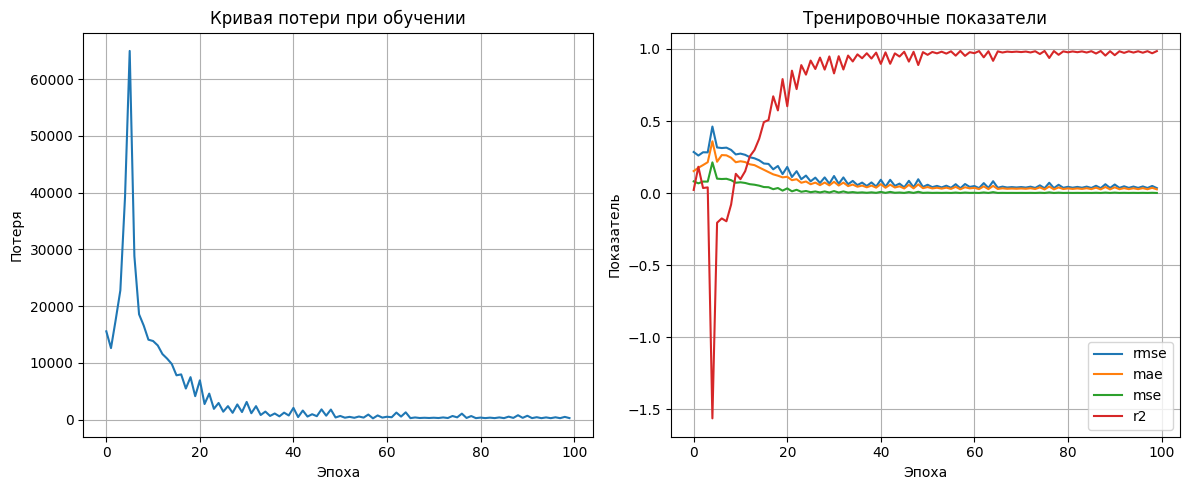

In [139]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

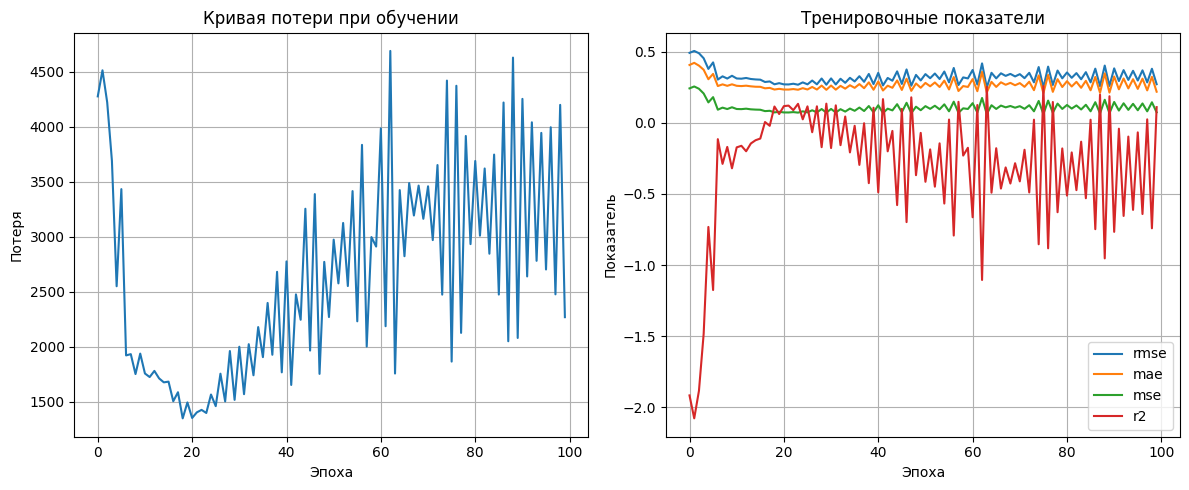

In [140]:
plot_training_history(
    train_results['val_loss'],
    {
        'rmse': train_results['val_rmse'],
        'mae': train_results['val_mae'],
        'mse': train_results['val_mse'],
        'r2': train_results['val_r2'],
    }
)

In [377]:
len(test_loader)

113

In [141]:
# model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data)
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [142]:
# test_results = test(model, test_loader, device)

# test_results

In [143]:
# plot_predictions_vs_actuals(
#     test_results['test_targets'],
#     test_results['test_preds']
# )

In [144]:
# test_results['test_targets'], test_results['test_preds']

100%|██████████| 94/94 [00:00<00:00, 737.45it/s]


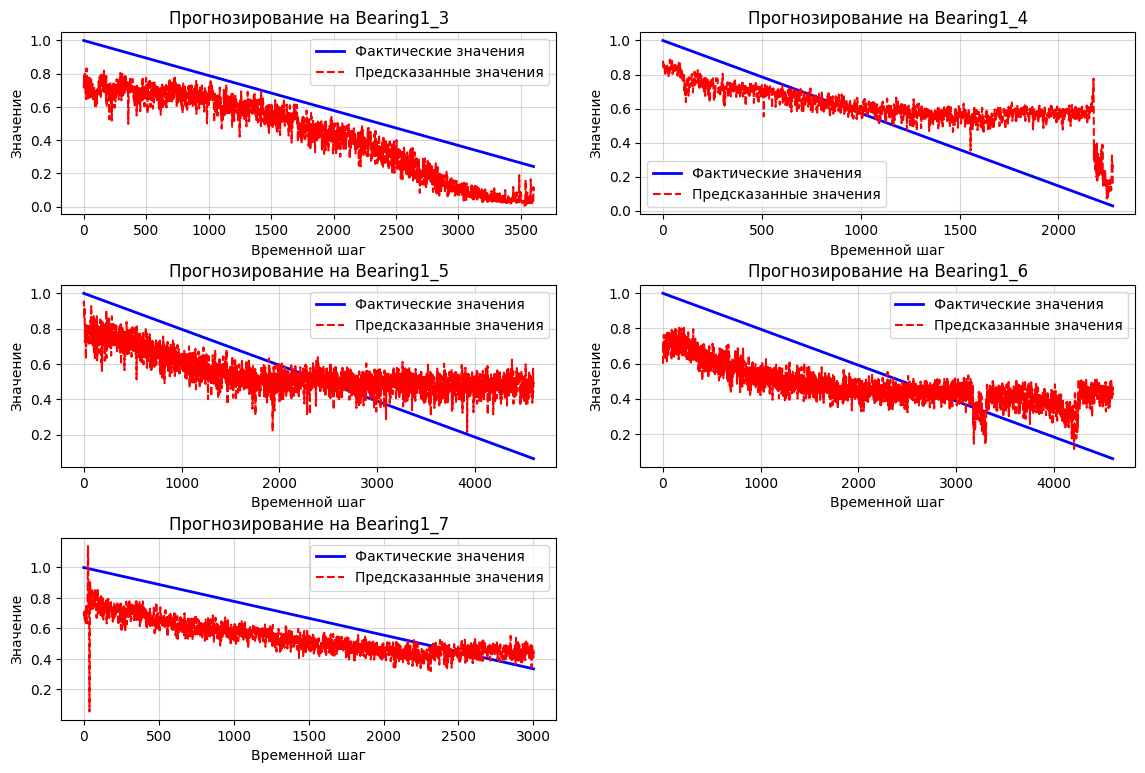

In [145]:
y_true_list = []
y_pred_list = []
titles = []
test_results_list = []

for bearing in TEST_BEARINGS[1]:
    titles.append(f"Прогнозирование на Bearing" + bearing)

    test_dataset = BearingDataset(
        df=df[1][df[1]['unit'] == bearing],
    )

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_results = test(model, test_loader, device)
    y_true_list.append(test_results['test_targets'])
    y_pred_list.append(test_results['test_preds'])
    test_results_list.append({
        'test_r2': test_results['test_r2'],
        'test_mae': test_results['test_mae'],
        'test_mse': test_results['test_mse'],
        'test_rmse': test_results['test_rmse'],
    })

plot_predictions_grid(
    y_true_list=y_true_list,
    y_pred_list=y_pred_list,
    titles=titles,
)